# Discharge Notes and Readmission Rates: Additional Features

In this notebook, I took the text data that has been processed through vectorizer and models from the NLP notebook, merged with other patient data features, and ran the data again through models to see if if I can get better scores than just with the text data. Please see the following for the other notebooks:
* [EDA Notebook](01_EDA.ipynb)
* [NLP Modeling Notebook](02_Modeling_NLP.ipynb)

## Import

Import the relevant libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#import xgboost as xg
from sklearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.utils import class_weight

## Functions

This section is for any functions created for the analysis.

In [2]:
def scores(model, X, y, set_type, return_conf=False):
    '''
    This function takes in an already fitted model, X, y, and
    the type of data (train, validation, or test) in str format,
    and prints out the accuracy and recall scores. The function
    also prints out the confusion matrix
    '''
    pred = model.predict(X)
    acc_score = accuracy_score(y, pred)
    rec_score = recall_score(y, pred)
    
    print("{} Scores".format(set_type))
    print("accuracy: ", acc_score)
    print("recall:   ", rec_score)
    fig, ax = plt.subplots(figsize=(6,6))
    #set background color to white
    fig.patch.set_facecolor('white')
    ax.set_title(set_type)
    plot_confusion_matrix(model, X, y, ax=ax)
    if return_conf == True:
        return fig, round(acc_score*100,1), round(rec_score*100,1)
    if return_conf == False:
        return round(acc_score*100,1), round(rec_score*100,1)

## Reading in the Data

Here, I read in the dataset with the NLP processed text data and the other patient data features. The first dataframe (df1) is with the predicted classification (0 no readmission or 1 readmission) in the TEXT column. The second dataframe (df1) is with the predicted probabilities of classes in the TEXT column.

In [3]:
df1 = pd.read_csv("data/admissions_nlp_processed_1.csv.gz", compression='gzip')

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52726 entries, 0 to 52725
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      52726 non-null  object
 1   ADMISSION_LOCATION  52726 non-null  object
 2   DISCHARGE_LOCATION  52726 non-null  object
 3   INSURANCE           52726 non-null  object
 4   LANGUAGE            52726 non-null  object
 5   RELIGION            52726 non-null  object
 6   MARITAL_STATUS      52726 non-null  object
 7   ETHNICITY           52726 non-null  object
 8   DIAGNOSIS           52726 non-null  object
 9   READMISSION         52726 non-null  int64 
 10  GENDER              52726 non-null  object
 11  AGE                 52726 non-null  int64 
 12  CPT_CD              52726 non-null  object
 13  DIAG_ICD9_CODE      52722 non-null  object
 14  DRG_CODE            52726 non-null  object
 15  PROCED_ICD9_CODE    52726 non-null  object
 16  TEXT                52

In [5]:
#originally had planned to break codes out, but the models were running too long, therefore had to drop code columns
df1.drop(['DIAG_ICD9_CODE','DRG_CODE', 'PROCED_ICD9_CODE'], axis=1, inplace=True)

In [6]:
df1['TEXT'].head()

0    1
1    0
2    0
3    0
4    1
Name: TEXT, dtype: int64

In [7]:
#set X as the text data, and y as the readmission status
X1 = df1.drop('READMISSION', axis=1)
y1 = df1['READMISSION']

In [8]:
df2 = pd.read_csv("data/admissions_nlp_processed_2.csv.gz", compression='gzip')

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52726 entries, 0 to 52725
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ADMISSION_TYPE      52726 non-null  object 
 1   ADMISSION_LOCATION  52726 non-null  object 
 2   DISCHARGE_LOCATION  52726 non-null  object 
 3   INSURANCE           52726 non-null  object 
 4   LANGUAGE            52726 non-null  object 
 5   RELIGION            52726 non-null  object 
 6   MARITAL_STATUS      52726 non-null  object 
 7   ETHNICITY           52726 non-null  object 
 8   DIAGNOSIS           52726 non-null  object 
 9   READMISSION         52726 non-null  int64  
 10  GENDER              52726 non-null  object 
 11  AGE                 52726 non-null  int64  
 12  CPT_CD              52726 non-null  object 
 13  DIAG_ICD9_CODE      52722 non-null  object 
 14  DRG_CODE            52726 non-null  object 
 15  PROCED_ICD9_CODE    52726 non-null  object 
 16  TEXT

In [10]:
#originally had planned to break codes out, but the models were running too long, therefore had to drop code columns
df2.drop(['DIAG_ICD9_CODE','DRG_CODE', 'PROCED_ICD9_CODE'], axis=1, inplace=True)

In [11]:
df2['TEXT'].head()

0    0.551149
1    0.367082
2    0.402644
3    0.282630
4    0.544221
Name: TEXT, dtype: float64

In [12]:
df2['READMISSION'].value_counts()

0    49715
1     3011
Name: READMISSION, dtype: int64

In [ ]:
#set X as the text data, and y as the readmission status
X2 = df2.drop('READMISSION', axis=1)
y2 = df2['READMISSION']

## Train, Validation, and Test Split

Here I split both dataframes into train, validation, and test sets.

In [14]:
X_train1, X_v_t1, y_train1, y_v_t1 = train_test_split(X1, y1, test_size=0.30, random_state=42, stratify=y1)

In [15]:
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_v_t1, y_v_t1, test_size=0.50, random_state=42, stratify=y_v_t1)

In [16]:
X_train1.shape

(36908, 13)

In [17]:
X_train2, X_v_t2, y_train2, y_v_t2 = train_test_split(X2, y2, test_size=0.30, random_state=42, stratify=y2)

In [18]:
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_v_t2, y_v_t2, test_size=0.50, random_state=42, stratify=y_v_t2)

In [19]:
X_train2.shape

(36908, 13)

## Handling Imbalanced Data 

Just as I had to handle the imbalanced classes in the previous notebook on NLP, I used the undersampling method to mitigate the impacts of the imbalanced classes.

In [20]:
#concat the train dataset together
train_df = pd.concat([y_train1, X_train1], axis=1)

In [21]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [22]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=len(train_df_pos), random_state=42)

In [23]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [24]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [25]:
#split out the X and y of the new dataset
y_train1 = new_train_df['READMISSION']
X_train1 = new_train_df.drop('READMISSION', axis=1)
max_feats_1 = int(X_train1.shape[0]*0.10)

In [26]:
#concat the train dataset together
train_df = pd.concat([y_train2, X_train2], axis=1)

In [27]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [28]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=len(train_df_pos), random_state=42)

In [29]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [30]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [31]:
#split out the X and y of the new dataset
y_train2 = new_train_df['READMISSION']
X_train2 = new_train_df.drop('READMISSION', axis=1)
max_feats_2 = int(X_train2.shape[0]*0.10)

## Pipeline Parameters

In this section, I set specific pipeline parameters that I will keep constant throughout the project.

In [32]:
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4216 entries, 35763 to 6932
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      4216 non-null   object
 1   ADMISSION_LOCATION  4216 non-null   object
 2   DISCHARGE_LOCATION  4216 non-null   object
 3   INSURANCE           4216 non-null   object
 4   LANGUAGE            4216 non-null   object
 5   RELIGION            4216 non-null   object
 6   MARITAL_STATUS      4216 non-null   object
 7   ETHNICITY           4216 non-null   object
 8   DIAGNOSIS           4216 non-null   object
 9   GENDER              4216 non-null   object
 10  AGE                 4216 non-null   int64 
 11  CPT_CD              4216 non-null   object
 12  TEXT                4216 non-null   int64 
dtypes: int64(2), object(11)
memory usage: 461.1+ KB


In [33]:
#set the numeric and categorical columns
X_num1 = ['AGE']
X_num1 = ['AGE', 'TEXT']
X_cat1 = df1.drop(['AGE', 'READMISSION'], axis=1).columns
X_cat2 = df2.drop(['AGE', 'READMISSION', 'TEXT'], axis=1).columns

In [34]:
#set up the column transfomer part of the pipeline
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False,
                          handle_unknown='ignore'))
    ])

c_transform1 = ColumnTransformer(transformers=[
    ('num', numTrans, X_num1),
    ('cat', catTrans, X_cat1)
    ])

c_transform2 = ColumnTransformer(transformers=[
    ('num', numTrans, X_num2),
    ('cat', catTrans, X_cat2)
    ])

## Modeling

### Model 0: Dummy Classification

For my Model 0, I run a simple dummy classifier.

In [35]:
#instatiate the pipeline with column transformer, PCA, and dummy classifier model
pp1 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified")) 
    ])

Train Scores
accuracy:  0.5026091081593927
recall:    0.5009487666034156
Validation Scores
accuracy:  0.4965229485396384
recall:    0.5176991150442478
Test Scores
accuracy:  0.49235048678720444
recall:    0.4811529933481153


(49.2, 48.1)

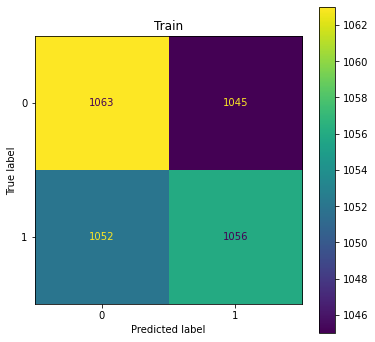

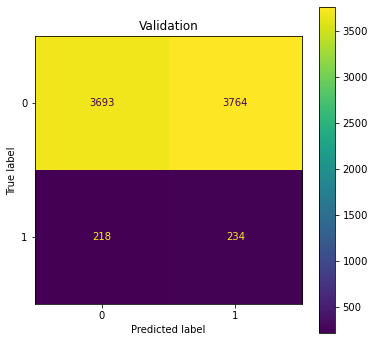

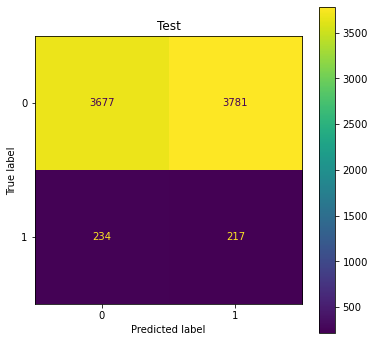

In [36]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp1.fit(X_train1, y_train1)

scores(pp1, X_train1, y_train1, 'Train')
scores(pp1, X_val1, y_val1, 'Validation')
scores(pp1, X_test1, y_test1, 'Test')

In [37]:
#instatiate the pipeline with column transformer, PCA, and dummy classifier model
pp2 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_2, random_state=42)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified")) 
    ])

Train Scores
accuracy:  0.5026091081593927
recall:    0.5009487666034156
Validation Scores
accuracy:  0.4965229485396384
recall:    0.5176991150442478
Test Scores
accuracy:  0.49235048678720444
recall:    0.4811529933481153


(49.2, 48.1)

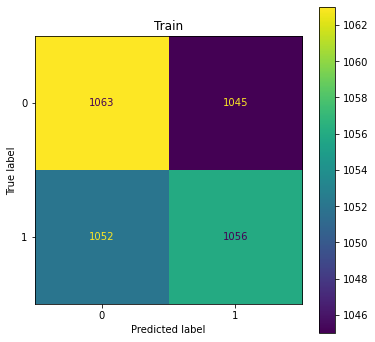

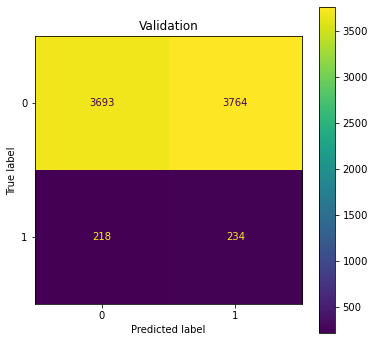

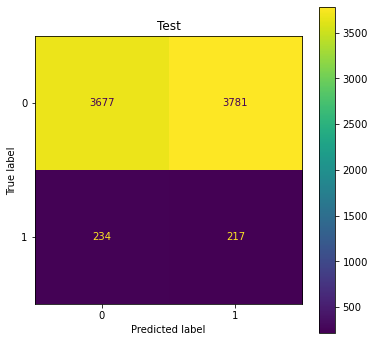

In [38]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp2.fit(X_train2, y_train2)

scores(pp2, X_train2, y_train2, 'Train')
scores(pp2, X_val2, y_val2, 'Validation')
scores(pp2, X_test2, y_test2, 'Test')

### Model 1: Logistic Regression

In [39]:
#instatiate the pipeline with column transformer, PCA, and logistic regression model
pp1 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('logreg', LogisticRegression(random_state=42)) 
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7084914611005693
recall:    0.75426944971537
Validation Scores
accuracy:  0.594133265899608
recall:    0.7146017699115044
Test Scores
accuracy:  0.6098116070299658
recall:    0.6873614190687362


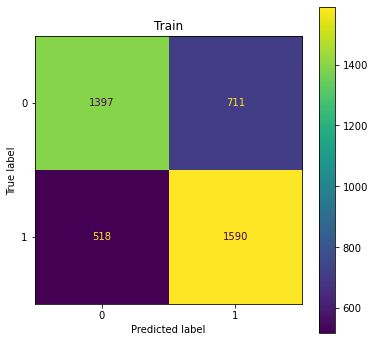

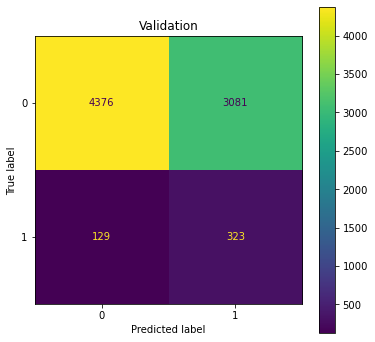

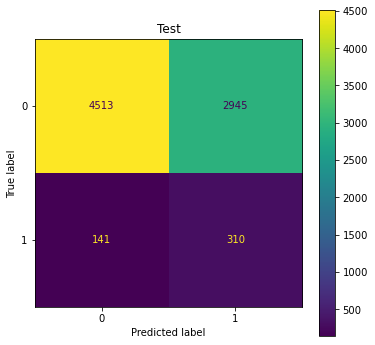

In [40]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp1.fit(X_train1, y_train1)

scores(pp1, X_train1, y_train1, 'Train')
scores(pp1, X_val1, y_val1, 'Validation')
log_acc, log_recall = scores(pp1, X_test1, y_test1, 'Test')

In [41]:
#instatiate the pipeline with column transformer, PCA, and logistic regression model
pp2 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_2, random_state=42)),
    ('logreg', LogisticRegression(random_state=42)) 
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7084914611005693
recall:    0.75426944971537
Validation Scores
accuracy:  0.594133265899608
recall:    0.7146017699115044
Test Scores
accuracy:  0.6098116070299658
recall:    0.6873614190687362


(61.0, 68.7)

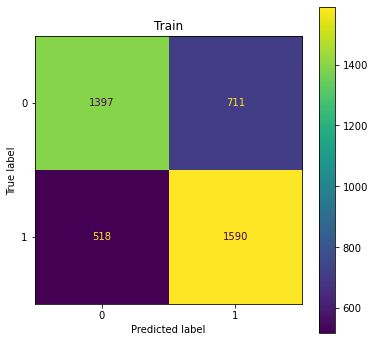

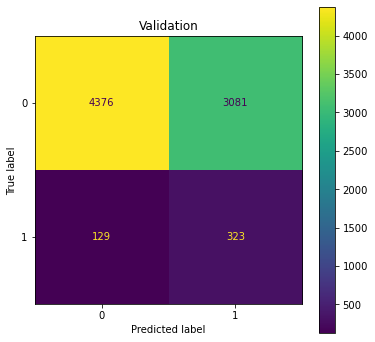

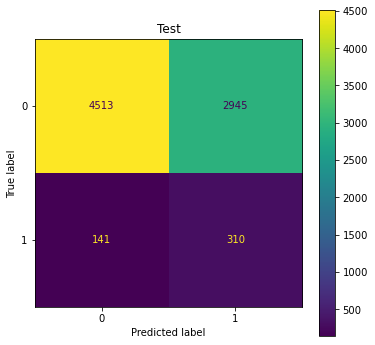

In [42]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp2.fit(X_train2, y_train2)

scores(pp2, X_train2, y_train2, 'Train')
scores(pp2, X_val2, y_val2, 'Validation')
scores(pp2, X_test2, y_test2, 'Test')

The dataframe with the predicted classification had the same scores as the dataframe with the predicted probabilities. Therefore, going forward, I will use just dataframe one, the dataframe with predicted classification.

### Model 2: Gaussian Naive Bayes

In [43]:
#instatiate the pipeline with column transformer, PCA, and gaussian Naive Bayes model
pp_gnb = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('gnb', GaussianNB()) 
    ])

Train Scores
accuracy:  0.6389943074003795
recall:    0.6992409867172675
Validation Scores
accuracy:  0.514730054368441
recall:    0.6637168141592921
Test Scores
accuracy:  0.5142243014287521
recall:    0.656319290465632


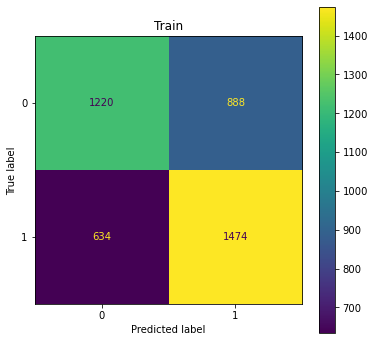

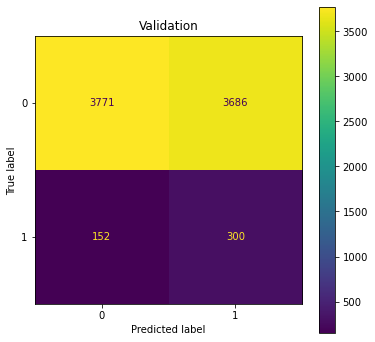

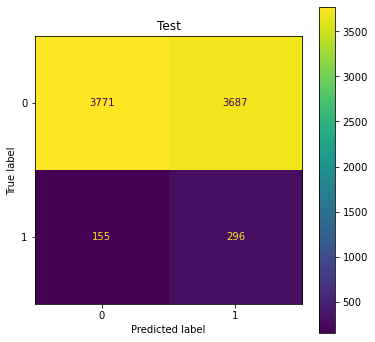

In [44]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_gnb.fit(X_train1, y_train1)

scores(pp_gnb, X_train1, y_train1, 'Train')
scores(pp_gnb, X_val1, y_val1, 'Validation')
gnb_acc, gnb_recall = scores(pp_gnb, X_test1, y_test1, 'Test')

### Model 3: Random Forest

In [45]:
#instatiate the pipeline with column transformer, PCA, and Random Forest model
pp_rf = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)) 
    ])

In [46]:
grid = {'rf__max_depth': [3,5,8,10],
        'rf__max_features': ['auto', 'sqrt'],
        'rf__min_samples_leaf': [2, 5, 10],
        'rf__min_samples_split': [2, 5, 7]}

In [47]:
#grid search
gs_rf = GridSearchCV(estimator=pp_rf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Train Scores
accuracy:  0.6826375711574952
recall:    0.8306451612903226
Validation Scores
accuracy:  0.4569477810089771
recall:    0.7942477876106194
Test Scores
accuracy:  0.46415476039954484
recall:    0.8159645232815964


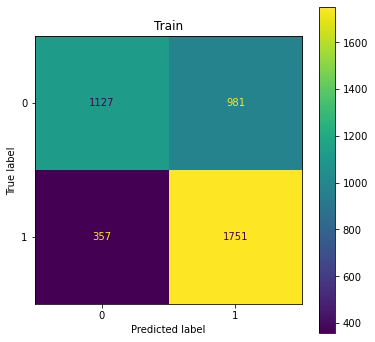

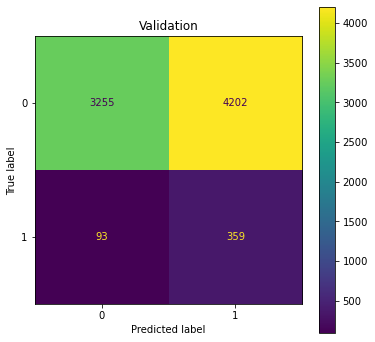

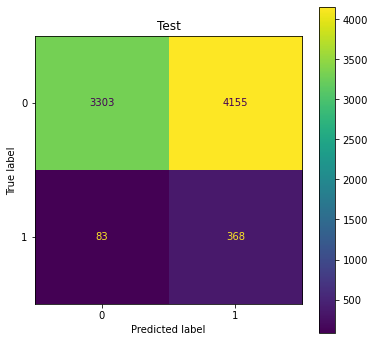

In [48]:
gs_rf.fit(X_train1, y_train1)

scores(gs_rf, X_train1, y_train1, 'Train')
scores(gs_rf, X_val1, y_val1, 'Validation')
rf_acc, rf_recall = scores(gs_rf, X_test1, y_test1, 'Test')

In [49]:
gs_rf.best_params_

{'rf__max_depth': 3,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 7}

In [50]:
"""
{'rf__max_depth': 3,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 7}
"""

"\n{'rf__max_depth': 3,\n 'rf__max_features': 'auto',\n 'rf__min_samples_leaf': 2,\n 'rf__min_samples_split': 7}\n"

In [51]:
#instatiate the pipeline with column transformer, PCA, and Random Forest model, with metrics from
#the grid search
pp_rf = Pipeline(steps=[('c_trans', c_transform),
                        ('pca', PCA(n_components=max_feats_1, random_state=42)),
                        ('rf', RandomForestClassifier(random_state=42,
                                                      max_depth=3,
                                                      max_features='auto',
                                                      min_samples_leaf=2,
                                                      min_samples_split=7)) 
    ])

Train Scores
accuracy:  0.6826375711574952
recall:    0.8306451612903226
Validation Scores
accuracy:  0.4569477810089771
recall:    0.7942477876106194
Test Scores
accuracy:  0.46415476039954484
recall:    0.8159645232815964


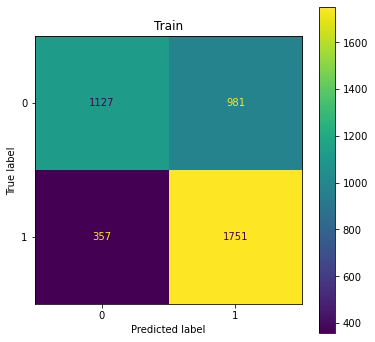

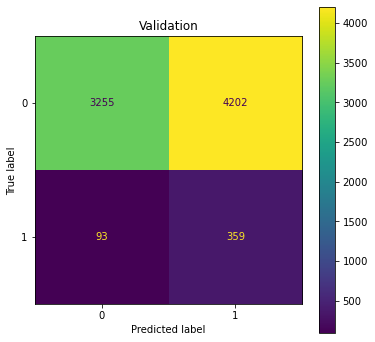

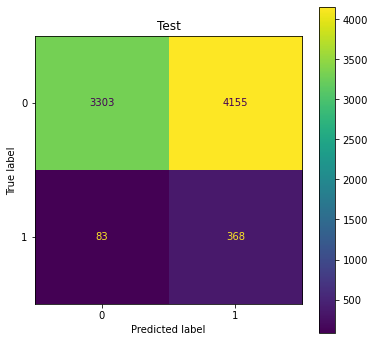

In [52]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_rf.fit(X_train1, y_train1)

scores(pp_rf, X_train1, y_train1, 'Train')
scores(pp_rf, X_val1, y_val1, 'Validation')
rf_acc, rf_recall = scores(pp_rf, X_test1, y_test1, 'Test')

Train Scores
accuracy:  0.7730075901328273
recall:    0.8287476280834914
Validation Scores
accuracy:  0.6176507775951448
recall:    0.6969026548672567
Test Scores
accuracy:  0.6318118599064357
recall:    0.7649667405764967

### Model 4: K-Nearest Neighbors

In [53]:
#instatiate the pipeline with column transformer, PCA, and KNN model
pp_knn = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('knn', KNeighborsClassifier())  
    ])

In [54]:
grid = {'knn__n_neighbors': list(range(19, 42, 2)),
        'knn__weights': ['uniform', 'distance'],
        'knn__p': [1, 2, 3, 4]}

In [55]:
#grid search
gs_knn = GridSearchCV(estimator=pp_knn, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Train Scores
accuracy:  0.99573055028463
recall:    0.99573055028463
Validation Scores
accuracy:  0.5314199013781767
recall:    0.7168141592920354
Test Scores
accuracy:  0.5352130484258439
recall:    0.6740576496674058


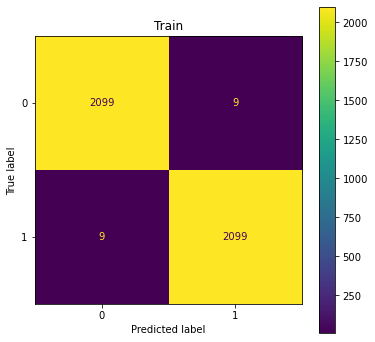

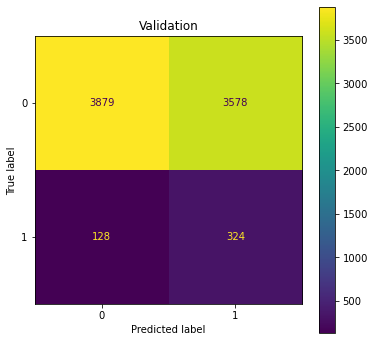

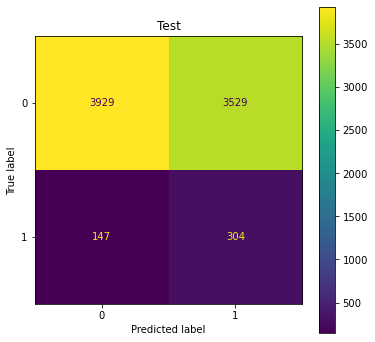

In [56]:
gs_knn.fit(X_train1, y_train1)

scores(gs_knn, X_train1, y_train1, 'Train')
scores(gs_knn, X_val1, y_val1, 'Validation')
knn_acc, knn_recall = scores(gs_knn, X_test1, y_test1, 'Test')

In [57]:
gs_knn.best_params_

{'knn__n_neighbors': 39, 'knn__p': 2, 'knn__weights': 'distance'}

In [58]:
"""
{'knn__n_neighbors': 19, 'knn__p': 2, 'knn__weights': 'uniform'}
"""

"\n{'knn__n_neighbors': 19, 'knn__p': 2, 'knn__weights': 'uniform'}\n"

In [59]:
#instatiate the pipeline with column transformer, PCA, and KNN model, with metrics from
#the grid search
pp_knn = Pipeline(steps=[('c_trans', c_transform),
                         ('pca', PCA(n_components=max_feats_1, random_state=42)),
                         ('knn', KNeighborsClassifier(n_neighbors=25,
                                                      p=2,
                                                      weights='uniform')) #adjusting the weights to uniform instead of distance helped with the overfitting 
     ])

Test Scores
accuracy:  0.547856871918068
recall:    0.6031042128603105
Test Scores
accuracy:  0.6883297509166773
recall:    0.44789356984478934
Test Scores
accuracy:  0.5493741307371349
recall:    0.6385809312638581
Test Scores
accuracy:  0.6352256922493362
recall:    0.5476718403547672
Test Scores
accuracy:  0.5503856366165129
recall:    0.6629711751662971
Test Scores
accuracy:  0.6067770893918321
recall:    0.6031042128603105
Test Scores
accuracy:  0.5459602983942344
recall:    0.6851441241685144
Test Scores
accuracy:  0.5917309394360855
recall:    0.6341463414634146
Test Scores
accuracy:  0.5450752307497787
recall:    0.6940133037694013
Test Scores
accuracy:  0.5821216335819952
recall:    0.6496674057649667
Test Scores
accuracy:  0.541534960171956
recall:    0.6917960088691796
Test Scores
accuracy:  0.5764319130104943
recall:    0.6297117516629712
Test Scores
accuracy:  0.5385004425338222
recall:    0.6629711751662971
Test Scores
accuracy:  0.5670754836262486
recall:    0.6452328159

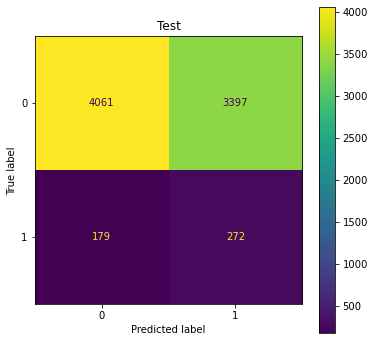

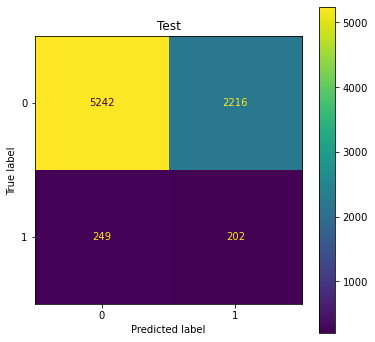

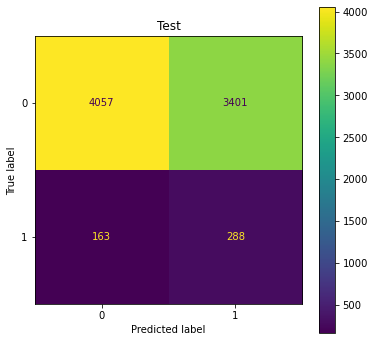

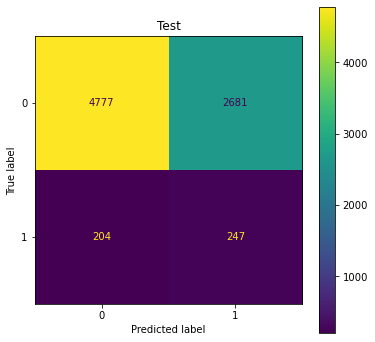

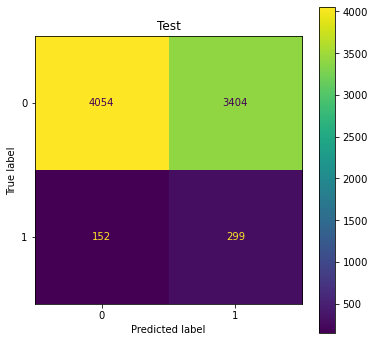

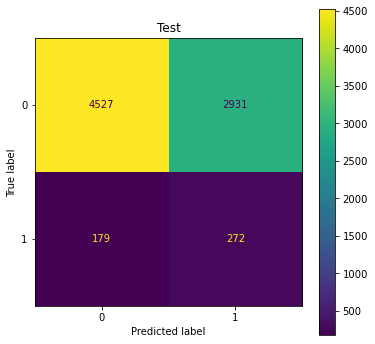

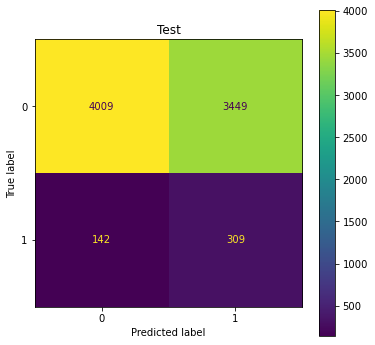

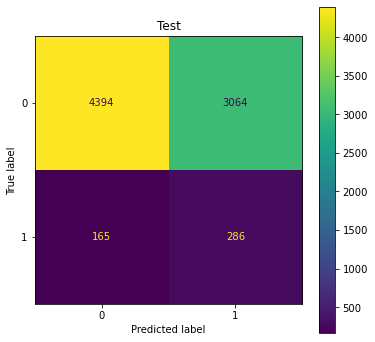

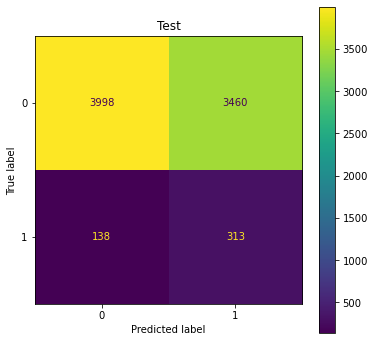

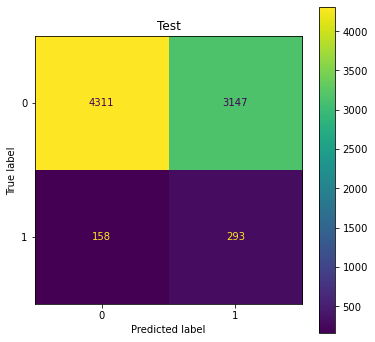

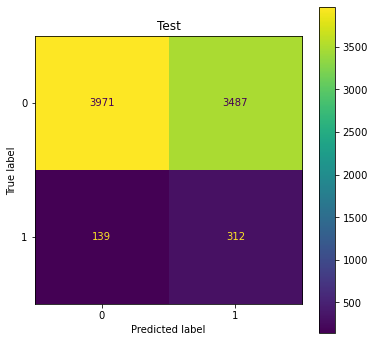

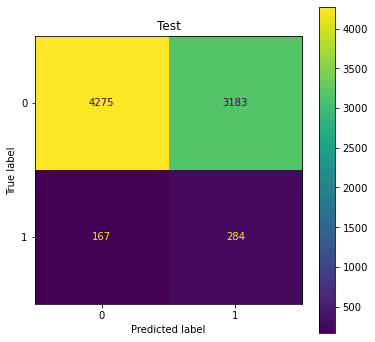

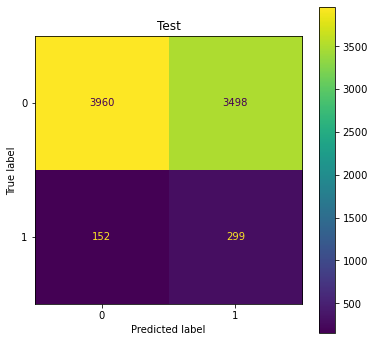

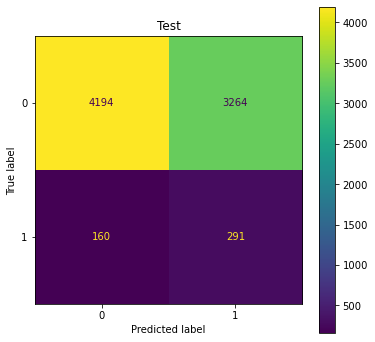

In [84]:
X = np.linspace(1,40, 14)
y1 = []
y2 = []
for i in X:
    pp_knn = Pipeline(steps=[('c_trans', c_transform),
                         ('pca', PCA(n_components=max_feats_1, random_state=42)),
                         ('knn', KNeighborsClassifier(n_neighbors=int(i),
                                                      p=2,
                                                      weights='uniform')) #adjusting the weights to uniform instead of distance helped with the overfitting 
     ])
    pp_knn.fit(X_train1, y_train1)
    knn_acc, knn_recall = scores(pp_knn, X_test1, y_test1, 'Test')
    y1.append(knn_recall)
    y2.append(knn_acc)

Train Scores
accuracy:  0.659629981024668
recall:    0.7277039848197343
Validation Scores
accuracy:  0.5373624984195221
recall:    0.6902654867256637
Test Scores
accuracy:  0.5450752307497787
recall:    0.6940133037694013


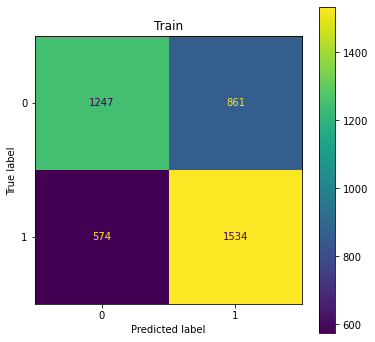

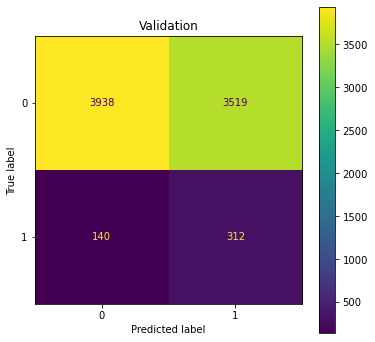

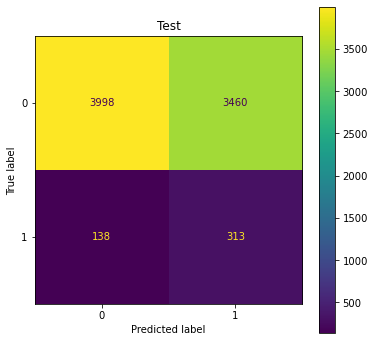

In [60]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_knn.fit(X_train1, y_train1)

scores(pp_knn, X_train1, y_train1, 'Train')
scores(pp_knn, X_val1, y_val1, 'Validation')
knn_acc, knn_recall = scores(pp_knn, X_test1, y_test1, 'Test')

### Model 5: Decision Tree Model

In [85]:
#instatiate the pipeline with column transformer, PCA, and Decision Tree model
pp_dt = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))  
    ])

In [86]:
grid = {'dt__criterion': ['gini', 'entropy'],
        'dt__max_depth': np.arange(1,17, 3),
        'dt__min_samples_split': np.arange(20, 101, 10),
        'dt__min_samples_leaf': np.arange(20, 101,10)
       }

In [87]:
#grid search
gs_dt = GridSearchCV(estimator=pp_dt, 
                      param_grid=grid, 
                      scoring='recall', #setting the scoring to f1 resulted in better scores
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Train Scores
accuracy:  0.5417457305502846
recall:    0.9952561669829222
Validation Scores
accuracy:  0.13756479959539764
recall:    0.9977876106194691
Test Scores
accuracy:  0.14110507017322038
recall:    0.9933481152993349


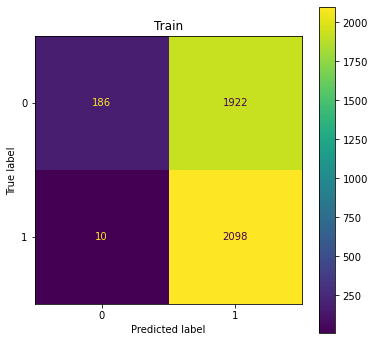

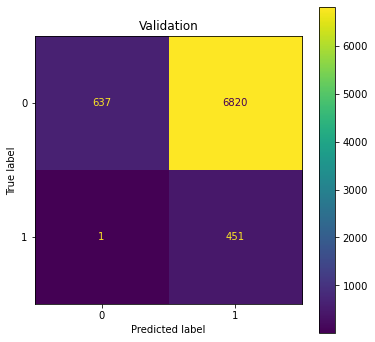

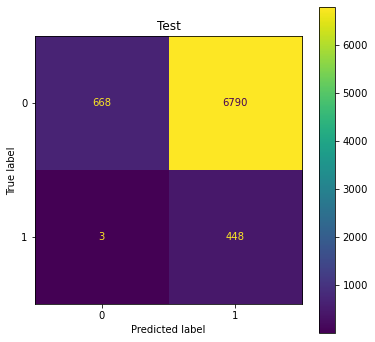

In [88]:
gs_dt.fit(X_train1, y_train1)

scores(gs_dt, X_train1, y_train1, 'Train')
scores(gs_dt, X_val1, y_val1, 'Validation')
dt_acc, dt_recall = scores(gs_dt, X_test1, y_test1, 'Test')

In [89]:
gs_dt.best_params_

{'dt__criterion': 'entropy',
 'dt__max_depth': 1,
 'dt__min_samples_leaf': 20,
 'dt__min_samples_split': 20}

In [66]:
"""
{'dt__criterion': 'entropy',
 'dt__max_depth': 4,
 'dt__min_samples_leaf': 20,
 'dt__min_samples_split': 60}
"""

"\n{'dt__criterion': 'entropy',\n 'dt__max_depth': 4,\n 'dt__min_samples_leaf': 20,\n 'dt__min_samples_split': 60}\n"

In [67]:
#instatiate the pipeline with column transformer, PCA, and Decision Tree model, with metrics from
#the grid search
pp_dt = Pipeline(steps=[('c_trans', c_transform),
                        ('pca', PCA(n_components=max_feats_1, random_state=42)),
                        ('dt', DecisionTreeClassifier(random_state=42,
                                                      criterion='entropy',
                                                      max_depth=4,
                                                      min_samples_leaf=20,
                                                      min_samples_split=60)) 
    ])

Train Scores
accuracy:  0.6017552182163188
recall:    0.607685009487666
Validation Scores
accuracy:  0.5665697306865596
recall:    0.5973451327433629
Test Scores
accuracy:  0.5752939688961942
recall:    0.5920177383592018


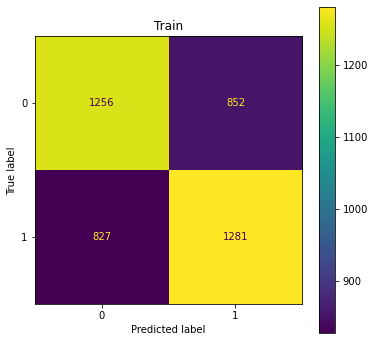

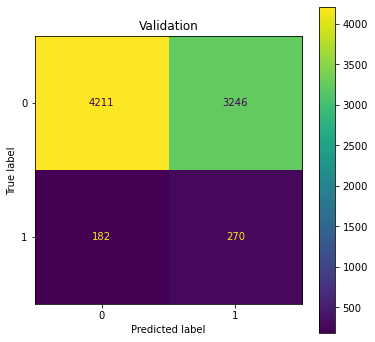

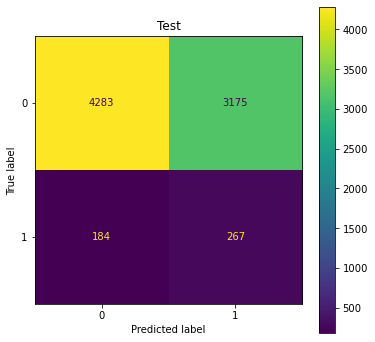

In [68]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_dt.fit(X_train1, y_train1)

scores(pp_dt, X_train1, y_train1, 'Train')
scores(pp_dt, X_val1, y_val1, 'Validation')
dt_acc, dt_recall = scores(pp_dt, X_test1, y_test1, 'Test')

### Model 6: Gradient Boost

In [90]:
#instatiate the pipeline with column transformer, PCA, and Gradient Boost model
pp1 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)), #reduce overfitting by passing less features
    ('gbc', GradientBoostingClassifier(random_state=42))  
    ])

In [91]:
grid = {'gbc__max_depth': np.arange(1,18, 4),
        'gbc__min_samples_split': np.arange(20, 101, 20),
        'gbc__min_samples_leaf': np.arange(20, 101,20)
       }

In [92]:
#grid search
gs_gbc = GridSearchCV(estimator=pp1, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

Fitting 3 folds for each of 125 candidates, totalling 375 fits
Train Scores
accuracy:  0.657258064516129
recall:    0.7670777988614801
Validation Scores
accuracy:  0.5114426602604628
recall:    0.7433628318584071
Test Scores
accuracy:  0.5181438867113415
recall:    0.7250554323725056


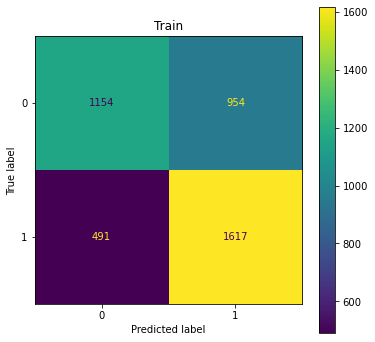

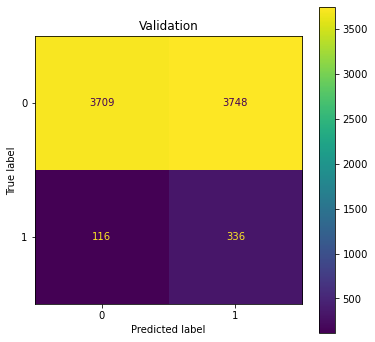

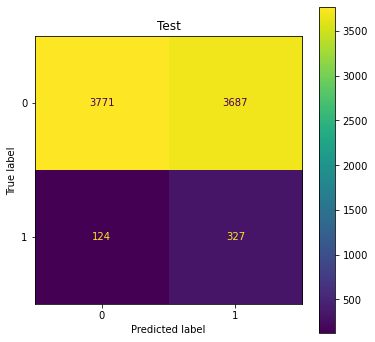

In [93]:
gs_gbc.fit(X_train1, y_train1)

scores(gs_gbc, X_train1, y_train1, 'Train')
scores(gs_gbc, X_val1, y_val1, 'Validation')
gbc_acc, gbc_recall = scores(gs_gbc, X_test1, y_test1, 'Test')

In [94]:
gs_gbc.best_params_

{'gbc__max_depth': 1,
 'gbc__min_samples_leaf': 40,
 'gbc__min_samples_split': 20}

In [ ]:
"""
{'gbc__max_depth': 3,
 'gbc__max_features': 'auto',
 'gbc__min_samples_split': 1000
"""

In [ ]:
#instatiate the pipeline with column transformer, PCA, and Gradient Boost model, with metrics from
#the grid search
pp_gbc = Pipeline(steps=[('c_trans', c_transform),
                         ('pca', PCA(n_components=int(0.1*max_feats_1), random_state=42)),
                         ('gbc', GradientBoostingClassifier(random_state=42,
                                                            max_depth=2,
                                                            max_features='auto',
                                                            min_samples_split=50))
    ])

In [ ]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_gbc.fit(X_train1, y_train1)

scores(pp_gbc, X_train1, y_train1, 'Train')
scores(pp_gbc, X_val1, y_val1, 'Validation')
gbc_acc, gbc_recall = scores(pp_gbc, X_test1, y_test1, 'Test')

### Model 7: Ensemble

In [ ]:
#instatiate the pipeline with column transformer, PCA, and logression regression model
pp_logreg = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('logreg', LogisticRegression(random_state=42))  
    ])

In [ ]:
#instatiate the voting classfier using the several models from above
voting_clf = VotingClassifier(estimators={("logreg", pp_logreg),
                                          #("gnb", pp_gnb), commented out to improve scores
                                          ("rf", pp_rf),
                                          ('knn', pp_knn),
                                          #('dt', pp_dt), commented out to improve scores
                                          ("gbc", pp_gbc)
                                        },
                              voting= "soft")

In [ ]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
voting_clf.fit(X_train1, y_train1)

scores(voting_clf, X_train1, y_train1, 'Train')
scores(voting_clf, X_val1, y_val1, 'Validation')
figure_test, vot_acc, vot_recall = scores(voting_clf, X_test1, y_test1, 'Test', return_conf=True)
figure_test.savefig('images/Model_Set2_Test_CF.png', bbox_inches='tight')

## Reviewing All Models:

In [ ]:
X_labels = ['Text''\n''Model','Logistic''\n''Regression', 'Gaussian''\n''Naive Bayes', 'Random''\n''Forest', 'KNN', 'Decision''\n''Tree', 'Gradient''\n''Boost', 'Ensemble''\n''(Vote)']
y1 = [70.1, log_recall, gnb_recall, rf_recall, knn_recall, dt_recall, gbc_recall, vot_recall]

In [ ]:
y2 = [62.2, log_acc, gnb_acc, rf_acc, knn_acc, dt_acc, gbc_acc, vot_acc]

In [ ]:
width = 0.35  # the width of the bars
x = np.arange(len(X_labels))
fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, y1, width, label='Sensitivity', color='royalblue')
rects2 = ax.bar(x + width/2, y2, width, label='Accuracy', color='lightblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores (%)')
ax.set_title('Model Sensitivity and Accuracy Scores')
ax.set_xticks(x)
ax.set_xticklabels(X_labels)
ax.legend(bbox_to_anchor=(1.15, 1.01))

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
#set background color to white
fig.patch.set_facecolor('white')
plt.show()
#save the figure in the images folder
fig.savefig('images/Model_Scores2.png', bbox_inches='tight')

## Setting Final Model

In [ ]:
#split the positive and negative data
df_pos = df1[df1['READMISSION']==1]
df_neg = df1[df1['READMISSION']==0]

In [ ]:
#take a sample of the negative training set with the same number of rows as positive dataset
df_neg_samp = df_neg.sample(n=len(df_pos), random_state=42)

In [ ]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_df = pd.concat([df_pos,df_neg_samp],axis=0)

In [ ]:
#randomize the new dataset
new_df = new_df.sample(n=len(new_df), random_state=42)

In [ ]:
#split out the X and y of the new dataset
new_y = new_df['READMISSION']
new_X = new_df.drop('READMISSION',axis=1)
new_max_feats = int(new_X.shape[0]*0.10)

In [ ]:
final_model = voting_clf

In [ ]:
final_model.fit(new_X, new_y)
final_acc, final_recall = scores(final_model, new_X, new_y, 'Final')